## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
LEARNING_RATE = 1e-3
EPOCHS = 20 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [12]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3,0.4,0.5]
redice_lr_patient = [1e-8,1e-10,1e-12]

In [13]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr =  ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=reduce_patient, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0811 10:15:51.738586  5616 deprecation_wrapper.py:119] From c:\users\susan01\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 0


W0811 10:15:51.893238  5616 deprecation_wrapper.py:119] From c:\users\susan01\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0811 10:15:51.901237  5616 deprecation_wrapper.py:119] From c:\users\susan01\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0811 10:15:51.970970  5616 deprecation.py:323] From c:\users\susan01\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 4s 84us/step - loss: 1.1378 - acc: 0.6069 - val_loss: 1.4611 - val_acc: 0.4909
Epoch 20/20
50000/50000 [==============================] - 4s 83us/step - loss: 1.1203 - acc: 0.6139 - val_loss: 1.4652 - val_acc: 0.4901
Numbers of exp: 2, reduce_factor: 0.30, reduce_patient: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

Epoch 17/20
50000/50000 [==============================] - 4s 90us/step - loss: 1.1798 - acc: 0.5911 - val_loss: 1.4556 - val_acc: 0.4855
Epoch 18/20
50000/50000 [==============================] - 5s 93us/step - loss: 1.1616 - acc: 0.5966 - val_loss: 1.4598 - val_acc: 0.4884
Epoch 19/20
50000/50000 [==============================] - 5s 91us/step - loss: 1.1444 - acc: 0.6041 - val_loss: 1.4587 - val_acc: 0.4865
Epoch 20/20
50000/50000 [==============================] - 5s 93us/step - loss: 1.1268 - acc: 0.6106 - val_loss: 1.4611 - val_acc: 0.4897
Numbers of exp: 4, reduce_factor: 0.40, reduce_patient: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
____________________________________________________________

50000/50000 [==============================] - 5s 96us/step - loss: 1.2502 - acc: 0.5647 - val_loss: 1.4848 - val_acc: 0.4793oss: 1.2480 - a
Epoch 15/20
50000/50000 [==============================] - 5s 100us/step - loss: 1.2294 - acc: 0.5724 - val_loss: 1.4780 - val_acc: 0.4773
Epoch 16/20
50000/50000 [==============================] - 5s 93us/step - loss: 1.2097 - acc: 0.5792 - val_loss: 1.4739 - val_acc: 0.4833
Epoch 17/20
50000/50000 [==============================] - 5s 104us/step - loss: 1.1904 - acc: 0.5888 - val_loss: 1.4691 - val_acc: 0.4806
Epoch 18/20
50000/50000 [==============================] - 5s 101us/step - loss: 1.1701 - acc: 0.5958 - val_loss: 1.4663 - val_acc: 0.4837
Epoch 19/20
50000/50000 [==============================] - 5s 96us/step - loss: 1.1536 - acc: 0.6029 - val_loss: 1.4591 - val_acc: 0.4875
Epoch 20/20
50000/50000 [==============================] - 5s 100us/step - loss: 1.1355 - acc: 0.6073 - val_loss: 1.4659 - val_acc: 0.4821
Numbers of exp: 6, reduce_f

50000/50000 [==============================] - 5s 93us/step - loss: 1.3009 - acc: 0.5487 - val_loss: 1.4898 - val_acc: 0.4776
Epoch 12/20
50000/50000 [==============================] - 5s 92us/step - loss: 1.2752 - acc: 0.5576 - val_loss: 1.4899 - val_acc: 0.4796
Epoch 13/20
50000/50000 [==============================] - 5s 93us/step - loss: 1.2545 - acc: 0.5651 - val_loss: 1.4758 - val_acc: 0.4813
Epoch 14/20
50000/50000 [==============================] - 5s 95us/step - loss: 1.2323 - acc: 0.5748 - val_loss: 1.4662 - val_acc: 0.4888
Epoch 15/20
50000/50000 [==============================] - 5s 95us/step - loss: 1.2104 - acc: 0.5811 - val_loss: 1.4662 - val_acc: 0.4879
Epoch 16/20
50000/50000 [==============================] - 5s 94us/step - loss: 1.1896 - acc: 0.5896 - val_loss: 1.4638 - val_acc: 0.4883
Epoch 17/20
50000/50000 [==============================] - 5s 92us/step - loss: 1.1709 - acc: 0.5970 - val_loss: 1.4692 - val_acc: 0.4901
Epoch 18/20
50000/50000 [=====================

Epoch 9/20
50000/50000 [==============================] - 5s 91us/step - loss: 0.9917 - acc: 0.6530 - val_loss: 1.8079 - val_acc: 0.3973
Epoch 10/20
50000/50000 [==============================] - 5s 94us/step - loss: 0.9499 - acc: 0.6699 - val_loss: 1.8816 - val_acc: 0.4118
Epoch 11/20
50000/50000 [==============================] - 5s 92us/step - loss: 0.8998 - acc: 0.6881 - val_loss: 1.9412 - val_acc: 0.3919
Epoch 12/20
50000/50000 [==============================] - 5s 91us/step - loss: 0.8604 - acc: 0.7026 - val_loss: 1.8539 - val_acc: 0.4265
Epoch 13/20
50000/50000 [==============================] - 5s 92us/step - loss: 0.8175 - acc: 0.7170 - val_loss: 1.8000 - val_acc: 0.4170

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 14/20
50000/50000 [==============================] - 5s 91us/step - loss: 0.6890 - acc: 0.7731 - val_loss: 1.4632 - val_acc: 0.5059
Epoch 15/20
50000/50000 [==============================] - 5s 92us/step - loss: 0.6283 - acc

Epoch 5/20
50000/50000 [==============================] - 5s 93us/step - loss: 1.4725 - acc: 0.4851 - val_loss: 1.5880 - val_acc: 0.4364
Epoch 6/20
50000/50000 [==============================] - 5s 93us/step - loss: 1.4364 - acc: 0.4988 - val_loss: 1.5692 - val_acc: 0.4548
Epoch 7/20
50000/50000 [==============================] - 5s 92us/step - loss: 1.4055 - acc: 0.5099 - val_loss: 1.5511 - val_acc: 0.4590
Epoch 8/20
50000/50000 [==============================] - 5s 93us/step - loss: 1.3786 - acc: 0.5194 - val_loss: 1.5426 - val_acc: 0.4625
Epoch 9/20
50000/50000 [==============================] - 5s 94us/step - loss: 1.3555 - acc: 0.5288 - val_loss: 1.5274 - val_acc: 0.4615
Epoch 10/20
50000/50000 [==============================] - 5s 93us/step - loss: 1.3329 - acc: 0.5372 - val_loss: 1.5070 - val_acc: 0.4755
Epoch 11/20
50000/50000 [==============================] - 5s 96us/step - loss: 1.3123 - acc: 0.5465 - val_loss: 1.5054 - val_acc: 0.4740
Epoch 12/20
50000/50000 [==============

50000/50000 [==============================] - 5s 95us/step - loss: 1.6572 - acc: 0.4234 - val_loss: 1.7334 - val_acc: 0.3996
Epoch 3/20
50000/50000 [==============================] - 5s 95us/step - loss: 1.5545 - acc: 0.4576 - val_loss: 1.6586 - val_acc: 0.4108
Epoch 4/20
50000/50000 [==============================] - 5s 95us/step - loss: 1.4899 - acc: 0.4804 - val_loss: 1.6171 - val_acc: 0.4364
Epoch 5/20
50000/50000 [==============================] - 5s 95us/step - loss: 1.4443 - acc: 0.4963 - val_loss: 1.5736 - val_acc: 0.4428
Epoch 6/20
50000/50000 [==============================] - 5s 100us/step - loss: 1.4052 - acc: 0.5104 - val_loss: 1.5693 - val_acc: 0.4434
Epoch 7/20
50000/50000 [==============================] - 5s 100us/step - loss: 1.3744 - acc: 0.5224 - val_loss: 1.5489 - val_acc: 0.4572
Epoch 8/20
50000/50000 [==============================] - 5s 100us/step - loss: 1.3480 - acc: 0.5323 - val_loss: 1.5195 - val_acc: 0.4675
Epoch 9/20
50000/50000 [=========================

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 144us/step - loss: 2.0174 - acc: 0.3209 - val_loss: 2.0127 - val_acc: 0.3312
Epoch 2/20
50000/50000 [==============================] - 5s 91us/step - loss: 1.6493 - acc: 0.4242 - val_loss: 1.7461 - val_acc: 0.3833
Epoch 3/20
50000/50000 [==============================] - 4s 89us/step - loss: 1.5539 - acc: 0.4549 - val_loss: 1.6457 - val_acc: 0.4249
Epoch 4/20
50000/50000 [==============================] - 4s 87us/step - loss: 1.4918 - acc: 0.4766 - val_loss: 1.6091 - val_acc: 0.4409
Epoch 5/20
50000/50000 [==============================] - 4s 88us/step - loss: 1.4479 - acc: 0.4928 - val_loss: 1.5840 - val_acc: 0.4393
Epoch 6/20
50000/50000 [==============================] - 4s 87us/step - loss: 1.4112 - acc: 0.5047 - val_loss: 1.5588 - val_acc: 0.4512
Epoch 7/20
50000/50000 [==============================] - 4s 87us/step - loss: 1.3792 - acc: 0.5192 - val_loss: 1.5244 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 144us/step - loss: 2.0275 - acc: 0.3173 - val_loss: 2.0065 - val_acc: 0.3331
Epoch 2/20
50000/50000 [==============================] - 5s 91us/step - loss: 1.6646 - acc: 0.4183 - val_loss: 1.7351 - val_acc: 0.4002
Epoch 3/20
50000/50000 [==============================] - 5s 91us/step - loss: 1.5659 - acc: 0.4543 - val_loss: 1.6603 - val_acc: 0.4173
Epoch 4/20
50000/50000 [==============================] - 5s 91us/step - loss: 1.5051 - acc: 0.4740 - val_loss: 1.6168 - val_acc: 0.4297
Epoch 5/20
50000/50000 [==============================] - 5s 91us/step - loss: 1.4615 - acc: 0.4912 - val_loss: 1.5950 - val_acc: 0.4362
Epoch 6/20
50000/50000 [==============================] - 5s 102us/step - loss: 1.4258 - acc: 0.5051 - val_loss: 1.5567 - val_acc: 0.4453
Epoch 7/20
50000/50000 [==============================] - 5s 91us/step - loss: 1.3946 - acc: 0.5160 - val_loss: 1.5391 - val_a

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 136us/step - loss: 2.0220 - acc: 0.3111 - val_loss: 1.9685 - val_acc: 0.3321
Epoch 2/20
50000/50000 [==============================] - 5s 91us/step - loss: 1.6969 - acc: 0.4072 - val_loss: 1.8865 - val_acc: 0.3634
Epoch 3/20
50000/50000 [==============================] - 5s 92us/step - loss: 1.5746 - acc: 0.4491 - val_loss: 1.6982 - val_acc: 0.4186
Epoch 4/20
50000/50000 [==============================] - 4s 89us/step - loss: 1.4970 - acc: 0.4762 - val_loss: 1.6742 - val_acc: 0.4152
Epoch 5/20
50000/50000 [==============================] - 5s 90us/step - loss: 1.4338 - acc: 0.4978 - val_loss: 1.6028 - val_acc: 0.4363
Epoch 6/20
50000/50000 [==============================] - 4s 89us/step - loss: 1.3811 - acc: 0.5177 - val_loss: 1.5937 - val_acc: 0.4480
Epoch 7/20
50000/50000 [==============================] - 4s 89us/step - loss: 1.3373 - acc: 0.5345 - val_loss: 1.6267 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 145us/step - loss: 2.3360 - acc: 0.2279 - val_loss: 2.1928 - val_acc: 0.2696
Epoch 2/20
50000/50000 [==============================] - 5s 94us/step - loss: 1.9827 - acc: 0.3191 - val_loss: 1.9853 - val_acc: 0.3310
Epoch 3/20
50000/50000 [==============================] - 5s 97us/step - loss: 1.8418 - acc: 0.3627 - val_loss: 1.9024 - val_acc: 0.3544
Epoch 4/20
50000/50000 [==============================] - 5s 95us/step - loss: 1.7553 - acc: 0.3884 - val_loss: 1.8313 - val_acc: 0.3679
Epoch 5/20
50000/50000 [==============================] - 5s 93us/step - loss: 1.6919 - acc: 0.4096 - val_loss: 1.7712 - val_acc: 0.3867
Epoch 6/20
50000/50000 [==============================] - 5s 94us/step - loss: 1.6417 - acc: 0.4269 - val_loss: 1.7453 - val_acc: 0.3920
Epoch 7/20
50000/50000 [==============================] - 5s 94us/step - loss: 1.6004 - acc: 0.4393 - val_loss: 1.7185 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 150us/step - loss: 2.3436 - acc: 0.2251 - val_loss: 2.1890 - val_acc: 0.2729
Epoch 2/20
50000/50000 [==============================] - 5s 96us/step - loss: 1.9632 - acc: 0.3247 - val_loss: 2.0196 - val_acc: 0.3219
Epoch 3/20
50000/50000 [==============================] - 5s 100us/step - loss: 1.8212 - acc: 0.3700 - val_loss: 1.8881 - val_acc: 0.3519
Epoch 4/20
50000/50000 [==============================] - 5s 96us/step - loss: 1.7333 - acc: 0.3961 - val_loss: 1.8168 - val_acc: 0.3692
Epoch 5/20
50000/50000 [==============================] - 5s 96us/step - loss: 1.6721 - acc: 0.4182 - val_loss: 1.7762 - val_acc: 0.3857
Epoch 6/20
50000/50000 [==============================] - 5s 100us/step - loss: 1.6223 - acc: 0.4334 - val_loss: 1.7300 - val_acc: 0.3955
Epoch 7/20
50000/50000 [==============================] - 5s 102us/step - loss: 1.5818 - acc: 0.4470 - val_loss: 1.6901 - val

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 8s 159us/step - loss: 2.3685 - acc: 0.2320 - val_loss: 2.2328 - val_acc: 0.2757
Epoch 2/20
50000/50000 [==============================] - 5s 98us/step - loss: 1.9874 - acc: 0.3242 - val_loss: 2.0565 - val_acc: 0.3151
Epoch 3/20
50000/50000 [==============================] - 5s 95us/step - loss: 1.8418 - acc: 0.3654 - val_loss: 1.9174 - val_acc: 0.3539
Epoch 4/20
50000/50000 [==============================] - 5s 98us/step - loss: 1.7510 - acc: 0.3936 - val_loss: 1.8555 - val_acc: 0.3688
Epoch 5/20
50000/50000 [==============================] - 5s 95us/step - loss: 1.6845 - acc: 0.4145 - val_loss: 1.8051 - val_acc: 0.3853
Epoch 6/20
50000/50000 [==============================] - 5s 95us/step - loss: 1.6332 - acc: 0.4299 - val_loss: 1.7630 - val_acc: 0.3971
Epoch 7/20
50000/50000 [==============================] - 5s 103us/step - loss: 1.5902 - acc: 0.4452 - val_loss: 1.7200 - val_a

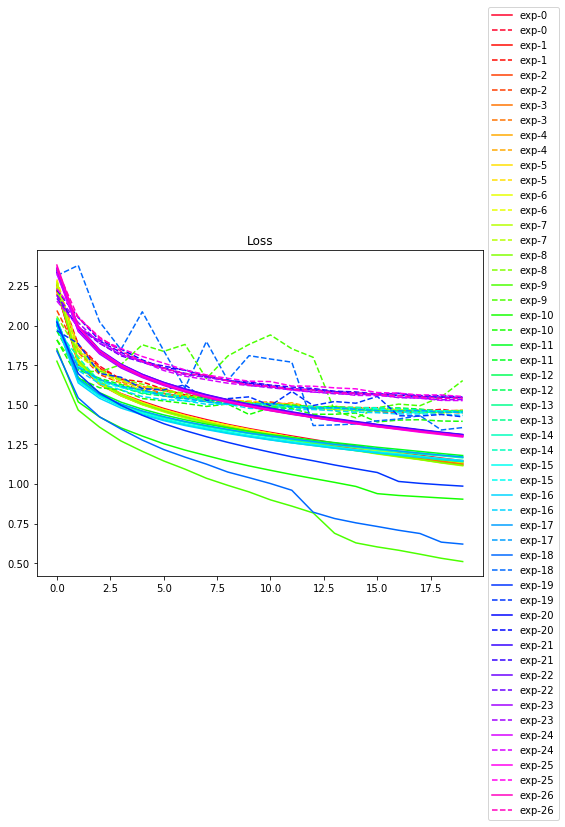

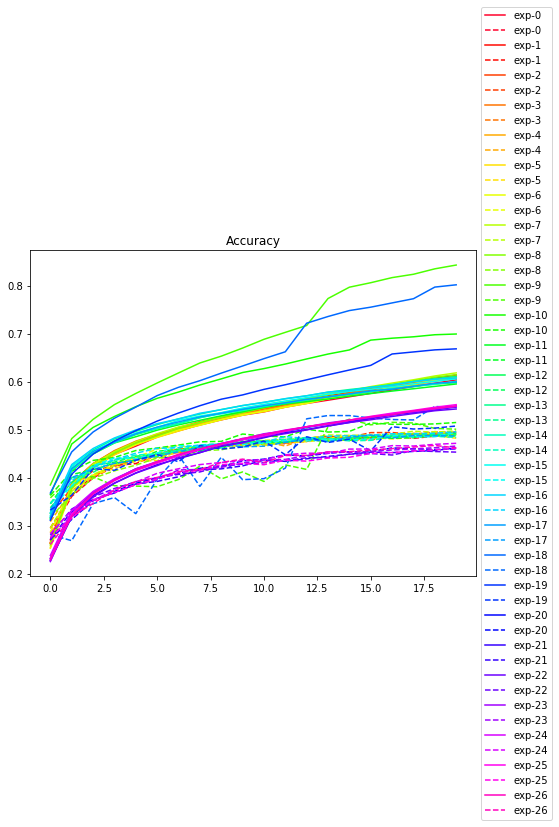

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()